In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import itertools
import math
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

### Enumerate Input Image Files

In [2]:
base_dir = '/media/MassStorage_WD/inbox/'
capture_dir = 'timelapse_test/'
path = base_dir + capture_dir
fps = 30
#skip_mult = 18
mean_mult = 60
# Limit to cut night off at
min_img_mean = 10

frame_files = [f for f in listdir(path) if isfile(join(path, f))]
frame_files.sort()

### Make a graph of change over time

In [55]:
diffs = []
diffs_smooth = []
diff_smooth = None
alpha = 0.25
img_last = None

for idx,file in enumerate(frame_files):
    filepath = path + file
    print(idx/len(frame_files), end='\r')
    img = cv2.imread(filepath).astype(np.float32)/255.0
    img = cv2.resize(img, (1080, 1920))
    if(img_last is not None):
        diffs += [np.sum(np.abs(img_last - img))]
        if(diff_smooth is None):
            diff_smooth = diffs[-1] 
        diff_smooth = diff_smooth*(1-alpha) + diffs[-1]*(alpha)
        diffs_smooth += [diff_smooth]
        
    img_last = img

35234.1798828125 (9501,)


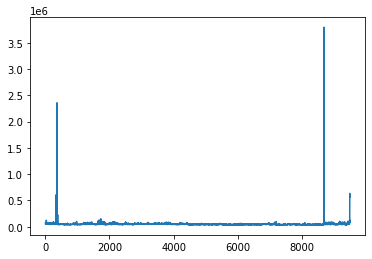

In [120]:
diffs = np.array(diffs)
# Generate the speed stats
vel_mean = np.mean(diffs)
vel_std = np.std(diffs)

dist_norm = (np.array(diffs)-vel_mean)/vel_std

outlier_prop = 0.1

outlier_limit = np.percentile(diffs, outlier_prop)

diffs_clean = diffs[diffs > outlier_limit]

print(outlier_limit, diffs_clean.shape)

#plt.plot(np.array(diffs))
#plt.plot(np.array(diffs_smooth))
plt.plot(diffs_clean)
plt.show()

In [5]:
# Play the video back in real time

for idx,file in enumerate(frame_files):
    filepath = path + file
    
    img = cv2.imread(filepath).astype(np.float32)/255.0
    # Add to buffer
    #img = tf.image.resize(img, (1080, 1920))
    img = tf.image.resize(img, (640, 720))
    
    cv2.imshow('frame', img.numpy())
    cv2.waitKey(1)

KeyboardInterrupt: 

50401.688 62864.61


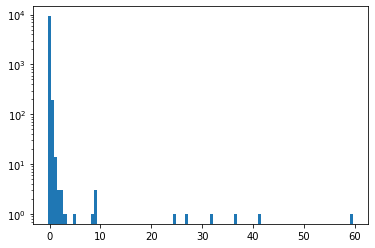

In [72]:

print(vel_mean, vel_std)
# Maximum frames squashed into 1 (speedup)
max_vel_scaling = 10
# Minimum speed 
min_vel_scaling = 1

plt.yscale('log')
#plt.hist(np.array(diffs), bins=100)
#plt.hist(np.array(diffs_smooth), bins=50)
plt.hist(np.array(dist_norm), bins=100)

plt.show()

In [93]:
fps = 24
frame_0 = cv2.imread(path+frame_files[0])
#frame_width = int(frame_0.shape[1])
#frame_height = int(frame_0.shape[0])
frame_width = int(1920)
frame_height = int(1080)
out = cv2.VideoWriter(path+'timelapse.avi', 
                      cv2.VideoWriter_fourcc('M','J','P','G'), 
                      fps, 
                      (frame_width,frame_height))

# Generate video w/ zoom and dynamic time
init_crop_scale = 1.0
fin_crop_scale  = 0.5

buff_len = 10
mean_buff = []

def calc_crop_factor(idx, count):
    return (init_crop_scale-fin_crop_scale)*idx/count+fin_crop_scale

for idx,file in enumerate(frame_files):
    print(100*idx/len(frame_files), '%', end='\r')
    
    if(idx == 0):
        crop_factor = calc_crop_factor(idx, len(frame_files))
        
    try: 
        velocity = diffs[idx]
    except: 
        pass

    # Read the image file
    filepath = path + file
    img = cv2.imread(filepath).astype(np.float32)/255.0
    # Crop it and resize
    img = tf.image.central_crop(img, crop_factor)

    # Resize to display dimensions
    img = tf.image.resize(img, (frame_height, frame_width))
    
    mean_buff += [img]
    
    if(len(mean_buff) > buff_len):
        img_out = tf.reduce_mean(tf.stack(mean_buff, axis=0), axis=0)
        img_out = (img_out*255.0).numpy().astype(np.uint8)

        out.write(img_out)
        # Recalc crop_factor
        crop_factor = calc_crop_factor(idx, len(frame_files))
        # Display
        cv2.imshow('frame', img_out)
        cv2.waitKey(1)
        
        mean_buff = []

out.release()

IndexError: list index out of range

In [94]:
out.release()

In [19]:
import datetime
def calc_duration(fps, num_frames):
    dur_secs = num_frames/fps
    res = datetime.timedelta(seconds =dur_secs)
    print(res)

In [22]:
calc_duration(30, len(frame_files))

0:05:17.066667


In [23]:
diffs

NameError: name 'diffs' is not defined

In [ ]:
# https://shotkit.com/f-stop-chart/
def estimate_lux(img, shutter_speed, iso, fstop):
    base_iso = 100
    img_sum = tf.reduce_sum(img)
    
    shutter_speed*img_sum/iso
    